# DuckDB performance issues

In the [first iterations](./1.1%20Eval%20-%20basic%20eval.ipynb) of our `eval`
SQL query, we constructed the query by manually adding a CTE for each hidden
layer in the neural network. We noticed that DuckDB started running into severe
performance issues once we started adding layers.

## Demonstration

The following code demonstrates the issue. We use [our perftest
framework](./utils/perftest.py) to measure timings.

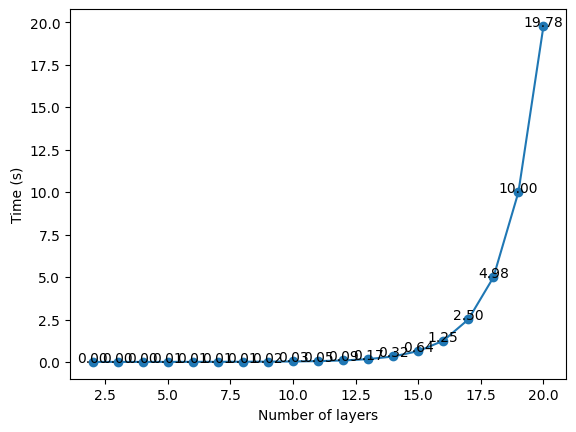

In [17]:
import duckdb
import random
import time
import matplotlib.pyplot as plt
import utils.perftest as perftest

con = duckdb.connect()

nodes_per_layer = 3

class DuckDBBugReportLayers(perftest.PerfTest):
    def setup_run(self, num_layers):
        con.sql("DROP TABLE IF EXISTS edge")
        con.sql("DROP TABLE IF EXISTS node")
        con.sql("DROP SEQUENCE IF EXISTS seq_node")

        con.sql("CREATE SEQUENCE seq_node START 1")

        con.sql(
            """
            CREATE TABLE node(
                id INTEGER PRIMARY KEY DEFAULT nextval('seq_node'),
                value REAL
            )"""
        )
        con.sql(
            """
            CREATE TABLE edge(
                src INTEGER,
                dst INTEGER,
                value REAL,
                FOREIGN KEY (src) REFERENCES node(id),
                FOREIGN KEY (dst) REFERENCES node(id)
            )"""
        )

        for _ in range(0, num_layers * nodes_per_layer):
            con.execute(
                "INSERT INTO node (value) VALUES ($value)",
                {'value': random.uniform(-10, 10)}
            )

        for layer in range(0, num_layers - 1):
            for i in range(0, nodes_per_layer):
                from_node_id = layer * nodes_per_layer + i + 1
                to_node_id = from_node_id + nodes_per_layer
                con.execute(
                    "INSERT INTO edge (src, dst, value) VALUES ($src, $dst, $value)",
                    {
                        'src': from_node_id,
                        'dst': to_node_id,
                        'value': random.uniform(-10, 10)
                    }
                )

    def run(self, num_layers):
        query = f"""
            WITH input_nodes AS (
                SELECT id, value
                FROM node
                WHERE id NOT IN
                (SELECT dst FROM edge)
            ),
            layer_1 AS (
                SELECT
                    e.dst,
                    i.value + e.value + n.value AS total
                FROM edge e
                JOIN input_nodes i ON i.id = e.src
                JOIN node n ON e.dst = n.id
                GROUP BY e.dst, i.value, e.value, n.value
            )
            """

        for layer in range(2, num_layers):
            curr = layer
            prev = layer - 1
            query += f""",
                layer_{curr} AS (
                    SELECT
                        e.dst,
                        layer_{prev}.total + e.value + n.value AS total
                    FROM edge e
                    JOIN layer_{prev} ON layer_{prev}.dst = e.src
                    JOIN node n ON e.dst = n.id
                    GROUP BY e.dst, layer_{prev}.total, e.value, n.value
                )
            """

        query += f"""
            SELECT * FROM layer_{num_layers - 1};
        """

        output = con.execute(query).fetchall()

    def x_labels(self):
        return [l for l in range(2, 21)]

df_duckdb_layers = perftest.measure_performance(DuckDBBugReportLayers())
perftest.plot_df(df_duckdb_layers, "Number of layers")

In this code, we create a database structure similar to our neural
network and run our `eval` query on it. We keep doing this while increasing the
number of hidden layers.

We can see that the time needed roughly doubles with every extra hidden layer.
This makes the `eval` query unusable for larger networks with DuckDB.

We opened an issue for this on
[Github](https://github.com/duckdb/duckdb/issues/13362).

## Comparison with SQLite

We'll do the exact same thing in SQLite and see how this compares to the DuckDB
implementation.

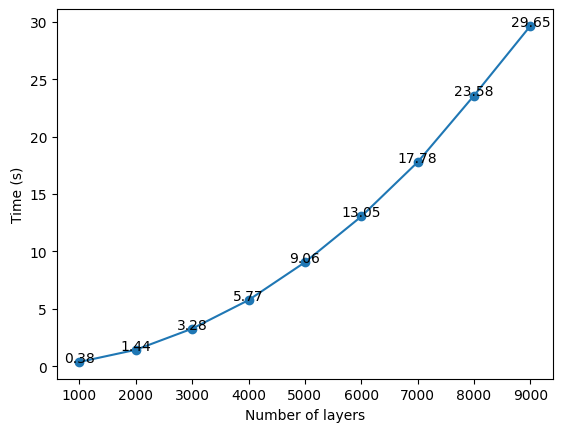

In [18]:
import sqlite3

con = sqlite3.connect('dbs/sqlite_test.db')

nodes_per_layer = 3

class DuckDBBugReportLayersSqlite(perftest.PerfTest):
    def setup_run(self, num_layers):
        con.execute("DROP TABLE IF EXISTS edge")
        con.execute("DROP TABLE IF EXISTS node")

        con.execute(
            """
            CREATE TABLE node(
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                value REAL
            )"""
        )
        con.execute(
            """
            CREATE TABLE edge(
                src INTEGER,
                dst INTEGER,
                value REAL,
                FOREIGN KEY (src) REFERENCES node(id),
                FOREIGN KEY (dst) REFERENCES node(id)
            )"""
        )

        for _ in range(0, num_layers * nodes_per_layer):
            con.execute(
                "INSERT INTO node (value) VALUES ($value)",
                {'value': random.uniform(-10, 10)}
            )

        # Now insert edges to create a DAG
        for layer in range(0, num_layers - 1):

            for i in range(0, nodes_per_layer):
                from_node_id = layer * nodes_per_layer + i + 1
                to_node_id = from_node_id + nodes_per_layer
                con.execute(
                    "INSERT INTO edge (src, dst, value) VALUES ($src, $dst, $value)",
                    {
                        'src': from_node_id,
                        'dst': to_node_id,
                        'value': random.uniform(-10, 10)
                    }
                )

    def run(self, num_layers):
        query = f"""
            WITH input_nodes AS (
                SELECT id, value
                FROM node
                WHERE id NOT IN
                (SELECT dst FROM edge)
            ),
            layer_1 AS (
                SELECT
                    e.dst,
                    i.value + e.value + n.value AS total
                FROM edge e
                JOIN input_nodes i ON i.id = e.src
                JOIN node n ON e.dst = n.id
                GROUP BY e.dst, i.value, e.value, n.value
            )
            """

        for layer in range(2, num_layers):
            curr = layer
            prev = layer - 1
            query += f""",
                layer_{curr} AS (
                    SELECT
                        e.dst,
                        layer_{prev}.total + e.value + n.value AS total
                    FROM edge e
                    JOIN layer_{prev} ON layer_{prev}.dst = e.src
                    JOIN node n ON e.dst = n.id
                    GROUP BY e.dst, layer_{prev}.total, e.value, n.value
                )
            """

        query += f"""
            SELECT * FROM layer_{num_layers - 1};
        """

        results = con.execute(query).fetchall()

    def x_labels(self):
        return [i * 1000 for i in range(1, 10)]

df_sqlite_layers = perftest.measure_performance(DuckDBBugReportLayersSqlite())
perftest.plot_df(df_sqlite_layers, "Number of layers")

We can see that SQLite appears to have better scaling, even when using 10000+
hidden layers. This makes it better for larger networks.

## DuckDB with recursive eval

The solution provided by DuckDB's maintainers is to use `WITH RECURSIVE` instead
of manually specifying the layers. Luckily, we already implemented this in a
[previous chapter](./1.4%20Eval%20-%20recursive.ipynb). Let's see how it
performs:

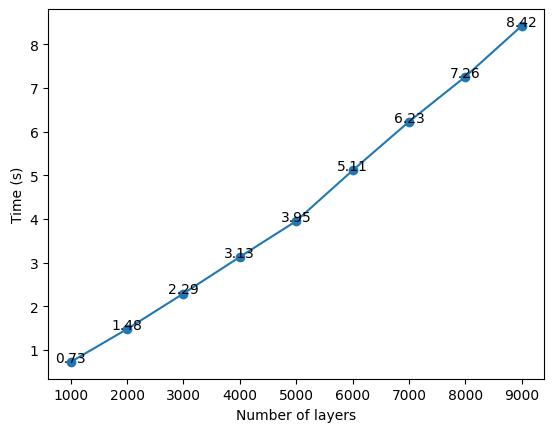

In [19]:
con = duckdb.connect()

nodes_per_layer = 3


class DuckDBBugReportLayersRecursive(perftest.PerfTest):
    def setup_run(self, num_layers):
        con.sql("DROP TABLE IF EXISTS edge")
        con.sql("DROP TABLE IF EXISTS node")
        con.sql("DROP SEQUENCE IF EXISTS seq_node")

        con.sql("CREATE SEQUENCE seq_node START 1")

        con.sql(
            """
            CREATE TABLE node(
                id INTEGER PRIMARY KEY DEFAULT nextval('seq_node'),
                value REAL
            )"""
        )
        con.sql(
            """
            CREATE TABLE edge(
                src INTEGER,
                dst INTEGER,
                value REAL,
                FOREIGN KEY (src) REFERENCES node(id),
                FOREIGN KEY (dst) REFERENCES node(id)
            )"""
        )

        for _ in range(0, num_layers * nodes_per_layer):
            con.execute(
                "INSERT INTO node (value) VALUES ($value)",
                {'value': random.uniform(-10, 10)}
            )

        # Now insert edges to create a DAG
        for layer in range(0, num_layers - 1):

            for i in range(0, nodes_per_layer):
                from_node_id = layer * nodes_per_layer + i + 1
                to_node_id = from_node_id + nodes_per_layer
                con.execute(
                    "INSERT INTO edge (src, dst, value) VALUES ($src, $dst, $value)",
                    {
                        'src': from_node_id,
                        'dst': to_node_id,
                        'value': random.uniform(-10, 10)
                    }
                )

    def run(self, num_layers):
        query = """
    WITH RECURSIVE input_nodes AS (
        SELECT id, value
        FROM node
        WHERE id NOT IN
        (SELECT dst FROM edge)
    ),
    output_nodes AS (
        SELECT id
        FROM node
        WHERE id NOT IN
        (SELECT src FROM edge)
    ),
    layers AS (
        SELECT
            e.dst,
            i.value + e.value + n.value AS total
        FROM input_nodes i
        JOIN edge e ON i.id = e.src
        JOIN node n ON e.dst = n.id
        GROUP BY e.dst, i.value, e.value, n.value

        UNION ALL

        SELECT
            e.dst,
            prev.total + e.value + n.value
        FROM layers prev
        JOIN edge e ON prev.dst = e.src
        JOIN node n ON e.dst = n.id
        GROUP BY e.dst, prev.total, e.value, n.value
    )
    SELECT l.*
    FROM layers l
    JOIN output_nodes o ON o.id = l.dst;
        """

        output = con.execute(query).fetchall()

    def x_labels(self):
        return [i * 1000 for i in range(1, 10)]

df_recursive = perftest.measure_performance(DuckDBBugReportLayersRecursive())
perftest.plot_df(df_recursive, "Number of layers")

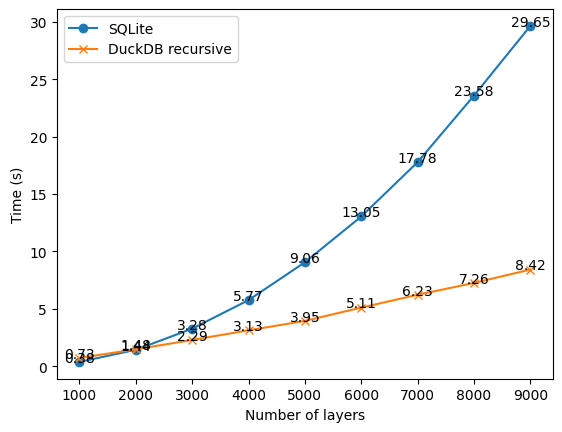

In [20]:
perftest.plot_dfs(
    [
        (df_sqlite_layers, "SQLite", "o"),
        (df_recursive, "DuckDB recursive", "x")
    ],
    "Number of layers"
)

We can see that DuckDB using a recursive `eval` query seems to scale linearly.
Moreover, it outperforms SQLite, taking less than half of the time.

## Conclusion

While DuckDB has severe scaling issues on the manually constructed `eval` query,
this problem disappears when using recursive queries. Even more, it achieves
better performance than SQLite in this case.